In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spicy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Now we will use a single song to explore our features

In [2]:
audio_path = './rawData/rock/1_Belki.mp3'
x , sr = librosa.load(audio_path, sr=44100)
print(type(x), type(sr))
print(x)
print(sr)

<class 'numpy.ndarray'> <class 'int'>
[-0.0085501  -0.00731279 -0.00675523 ... -0.00129233 -0.00096104
 -0.00071632]
44100


# The stft is the desibels of each frequency on the each time frame of 30 seconds in shape (n_freq_bins, n_frames)

(1025, 2560)


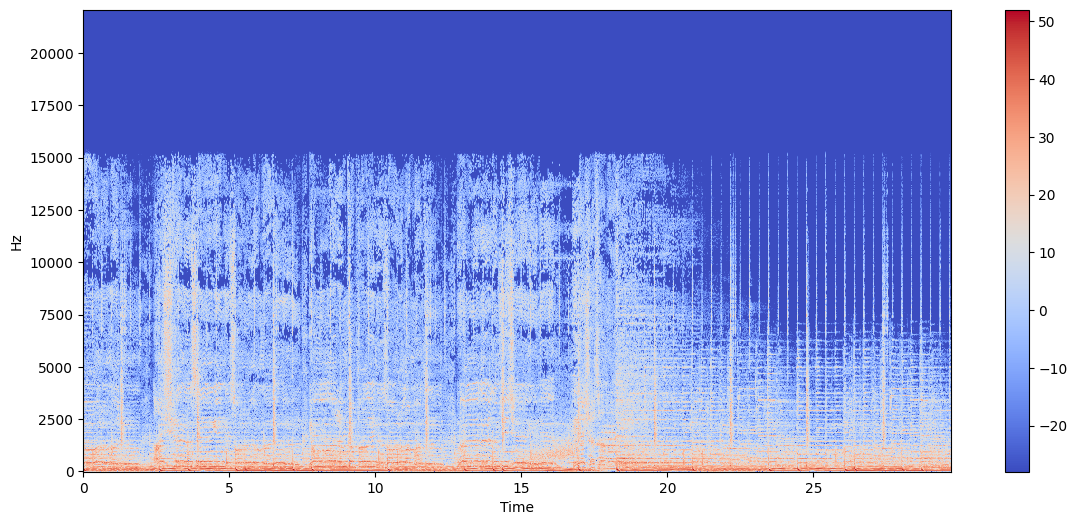

In [4]:
stft = librosa.stft(x)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

print(stft_db.shape)

# here we are taking the spectral_rolloff fro each time frame which means the frequency at which the freq above becomes noise which means that below this ferquency is the %85 of the music in that time frame which represents the important information

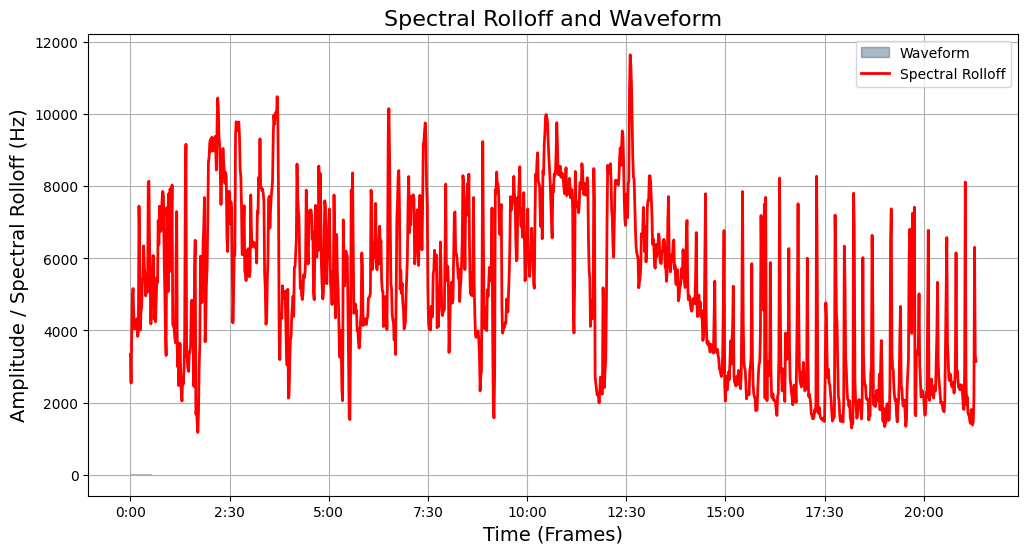

(1280,)


In [5]:
# Calculate the spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]

# Desired length of the spectral rolloff array
desired_length = 1280

# Interpolate the spectral rolloff to the desired length
if len(spectral_rolloff) != desired_length:
    # Create an interpolation function
    interp_func = interp1d(np.linspace(0, 1, len(spectral_rolloff)), spectral_rolloff, kind='linear')

    # Apply the interpolation to get the desired length
    spectral_rolloff = interp_func(np.linspace(0, 1, desired_length))
    
# Create a figure and plot both the waveform and the spectral rolloff
plt.figure(figsize=(12,6))

# Plot the waveform with some transparency
librosa.display.waveshow(x, sr=sr, alpha=0.4, color="#2B4F72", label="Waveform")

# Plot the spectral rolloff
plt.plot(spectral_rolloff, color="r", label="Spectral Rolloff", linewidth=2)

# Add labels and title
plt.title("Spectral Rolloff and Waveform", fontsize=16)
plt.xlabel("Time (Frames)", fontsize=14)
plt.ylabel("Amplitude / Spectral Rolloff (Hz)", fontsize=14)

# Add a legend to differentiate the curves
plt.legend(loc="upper right")

# Add a grid to make it easier to analyze the plot
plt.grid(True)

# Display the plot
plt.show()

# Print the spectral rolloff values
print(spectral_rolloff.shape)

# this one is the zero cross rate which is a count of how many times it goes back and forth between negative and positive amplitudes 

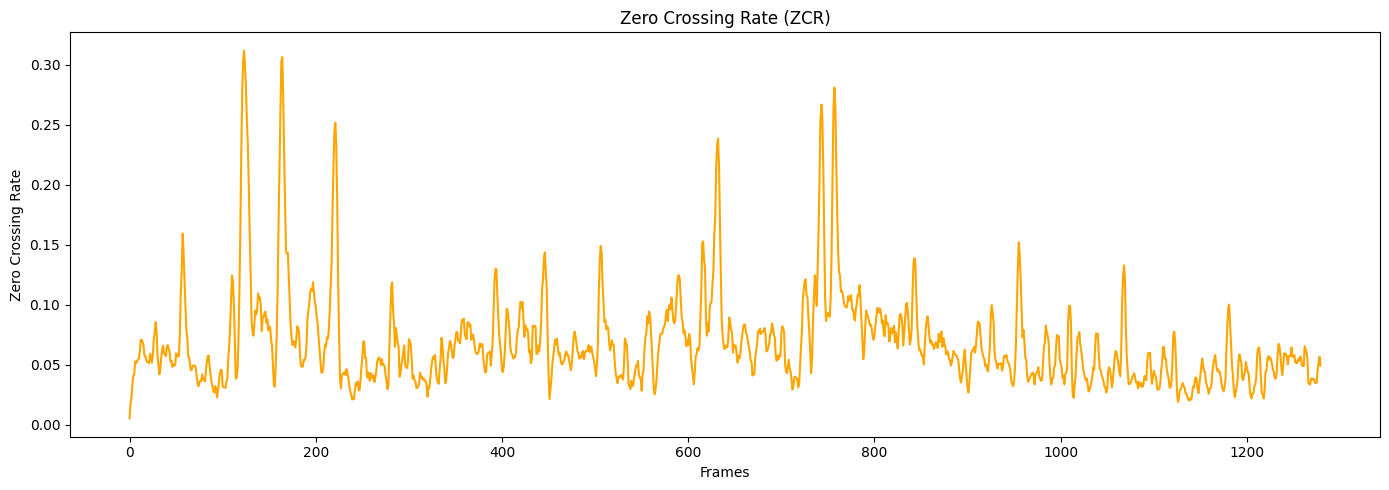

ZCR Shape: (1, 1280)


In [8]:
# Compute Zero Crossing Rate (ZCR)
zcr = librosa.feature.zero_crossing_rate(x)

# Plot the Zero Crossing Rate (ZCR)
plt.figure(figsize=(14, 5))
plt.plot(zcr[0], color="orange")
plt.title('Zero Crossing Rate (ZCR)')
plt.xlabel('Frames')
plt.ylabel('Zero Crossing Rate')
plt.tight_layout()
plt.show()

print("ZCR Shape:", zcr.shape)  # Print shape of ZCR for reference

# This is chroma which is the 12 notes amplitude for each time frame (12, n_frames), where: 12 corresponds to the 12 pitch classes (C, C#, D, etc.).

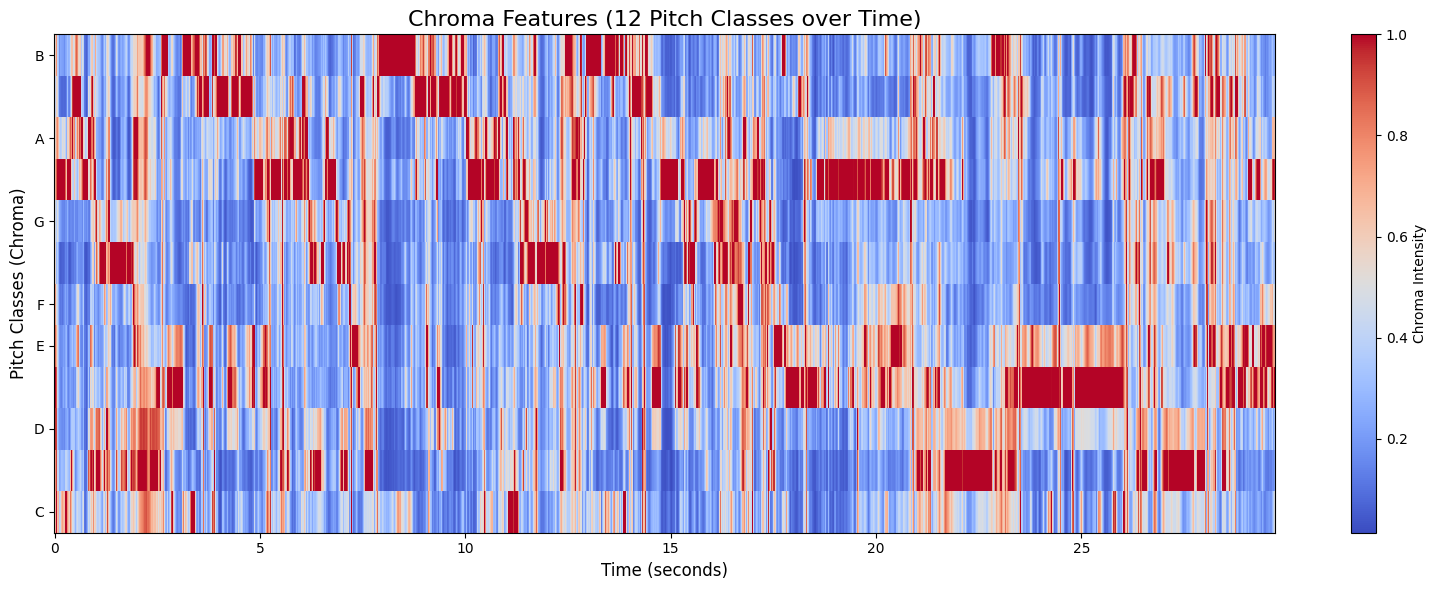

Shape of Chroma: (12, 1280)


In [9]:
# Compute Chroma feature (harmonic content across 12 pitch classes)
chroma = librosa.feature.chroma_stft(y=x, sr=sr)

# Plotting the chroma feature
plt.figure(figsize=(16,6))

# Create a spectrogram-like visualization of the chroma features
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')

# Adding a color bar for intensity scale
plt.colorbar(label='Chroma Intensity')

# Add title and axis labels
plt.title("Chroma Features (12 Pitch Classes over Time)", fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Pitch Classes (Chroma)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

# Print the shape of the chroma feature (12 chroma classes x n_frames)
print("Shape of Chroma:", chroma.shape)

# MFCCs (Mel-Frequency Cepstral Coefficients) are a feature extraction technique that represents the short-term power spectrum of an audio signal, capturing its timbral (tone quality) characteristics.

The Mel scale is based on how humans perceive pitch. In simple terms, humans perceive frequencies logarithmically—meaning our ears don't hear high frequencies as distinctly as low frequencies.

The Mel scale tries to represent this non-linear perception of sound by scaling frequency in a way that mimics human hearing, where the distance between frequencies increases as we go higher in pitch.

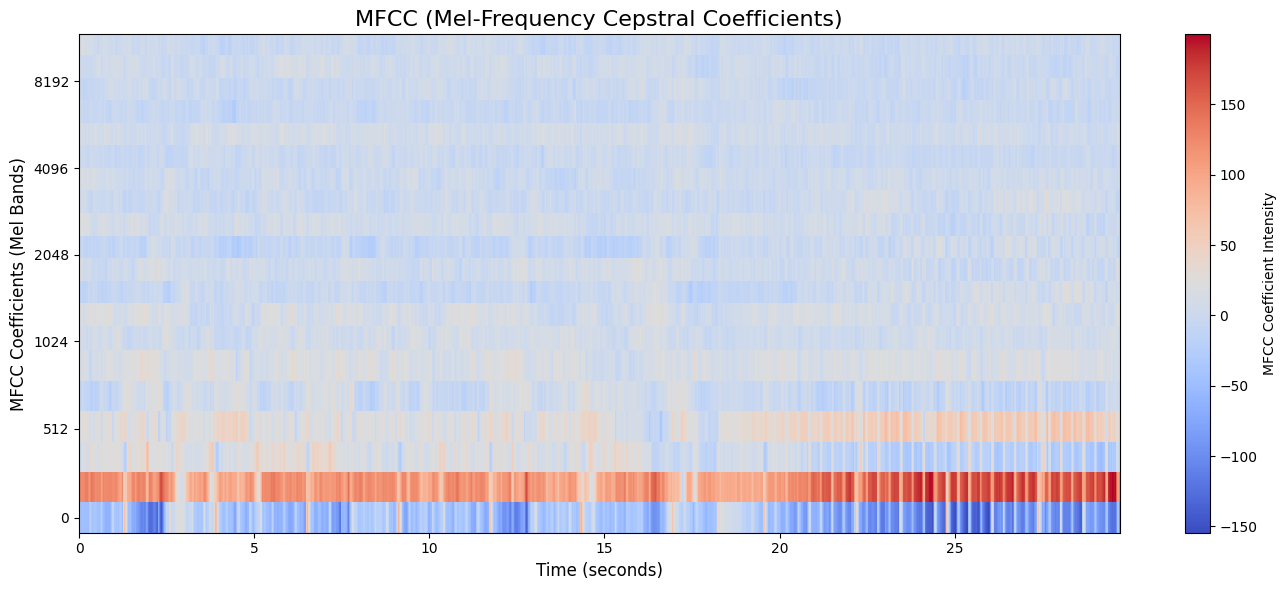

Shape of MFCCs: (20, 1280)


In [10]:
# Compute MFCCs (Mel-frequency cepstral coefficients)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

# Plot MFCCs with more informative labels
plt.figure(figsize=(14, 6))

# Display the MFCCs as a spectrogram-like image
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel')

# Add a color bar to represent the intensity of the coefficients
plt.colorbar(label='MFCC Coefficient Intensity')

# Set the title of the plot
plt.title('MFCC (Mel-Frequency Cepstral Coefficients)', fontsize=16)

# Set the x and y axis labels
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('MFCC Coefficients (Mel Bands)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Print the shape of the MFCCs array
print("Shape of MFCCs:", mfccs.shape)

# just a measure of how loud the sound is at a single time doesnt care about negative positive exmpahsizes big amplitudes (square)

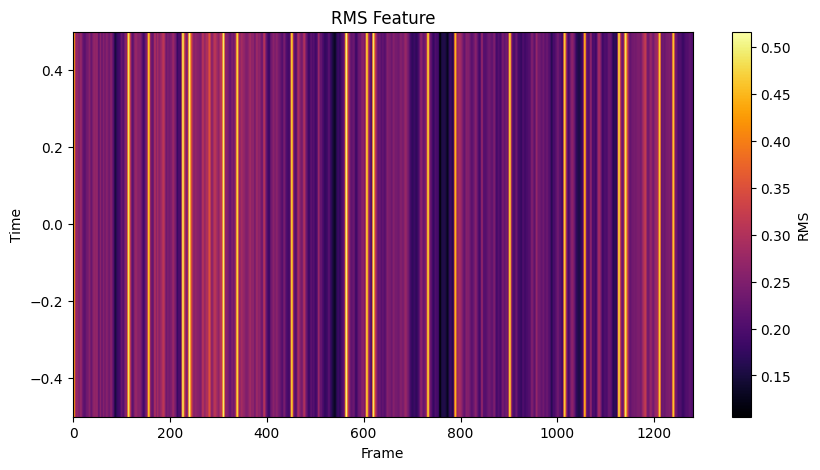

(1, 1280)


In [11]:
# Calculate RMS feature
rms = librosa.feature.rms(y=x)

# Plot RMS feature
plt.figure(figsize=(10, 5))
plt.imshow(rms, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='RMS')
plt.title('RMS Feature')
plt.xlabel('Frame')
plt.ylabel('Time')
plt.show()

print(rms.shape)

# what is the frequency hz where the sound is focused on it is obviously a 1D data

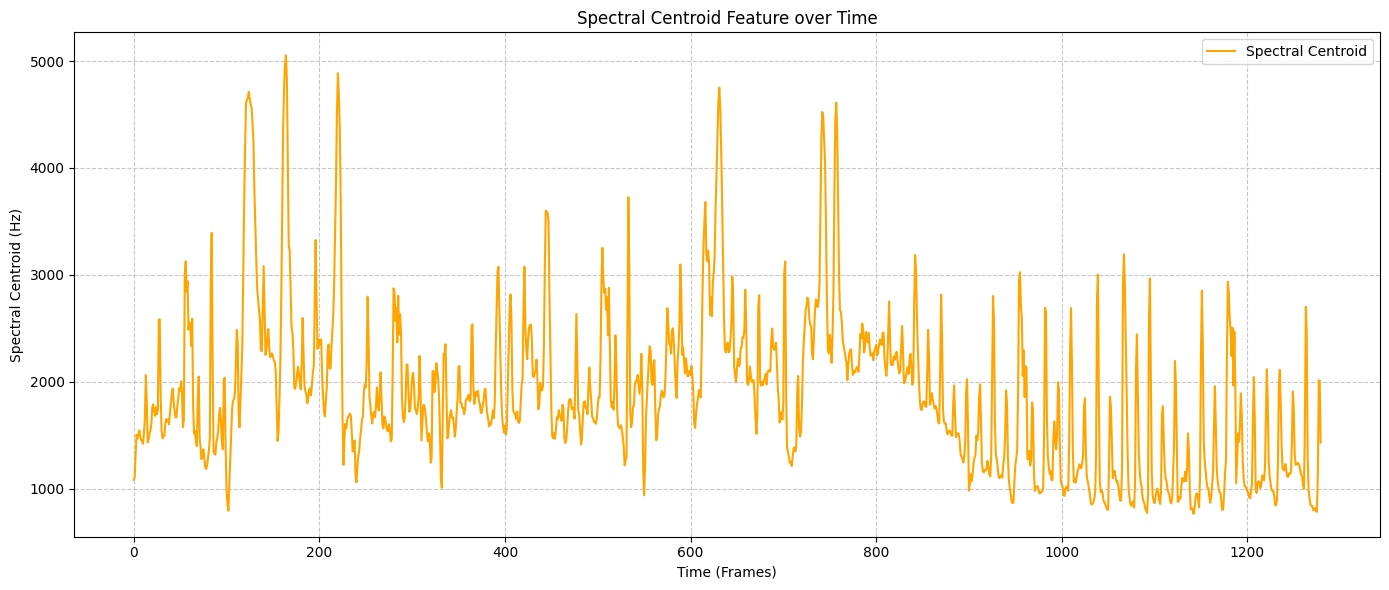

Spectral Centroid shape: (1, 1280)


In [12]:
# Calculate the Spectral Centroid feature
spectral_centroid = librosa.feature.spectral_centroid(y=x, sr=sr)

# Plotting the Spectral Centroid over time
plt.figure(figsize=(14, 6))
plt.plot(spectral_centroid.T, color='orange', label='Spectral Centroid')

# Add labels, title, and grid
plt.title('Spectral Centroid Feature over Time')
plt.xlabel('Time (Frames)')
plt.ylabel('Spectral Centroid (Hz)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Print shape of spectral centroid for reference
print("Spectral Centroid shape:", spectral_centroid.shape)